
Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        83
           1       0.62      0.91      0.74        11
           2       1.00      1.00      1.00       235
           3       1.00      0.94      0.97        17

    accuracy                           0.97       346
   macro avg       0.90      0.94      0.91       346
weighted avg       0.98      0.97      0.98       346



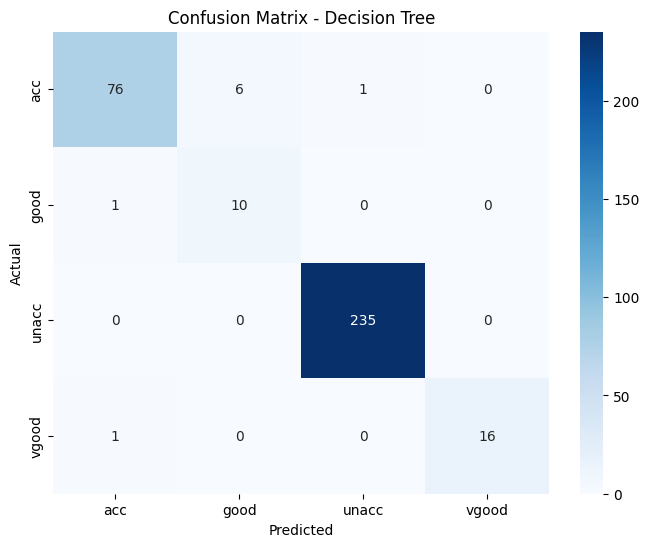


K-Nearest Neighbors Classifier:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76        83
           1       0.45      0.45      0.45        11
           2       0.91      1.00      0.95       235
           3       0.88      0.41      0.56        17

    accuracy                           0.88       346
   macro avg       0.77      0.64      0.68       346
weighted avg       0.87      0.88      0.87       346



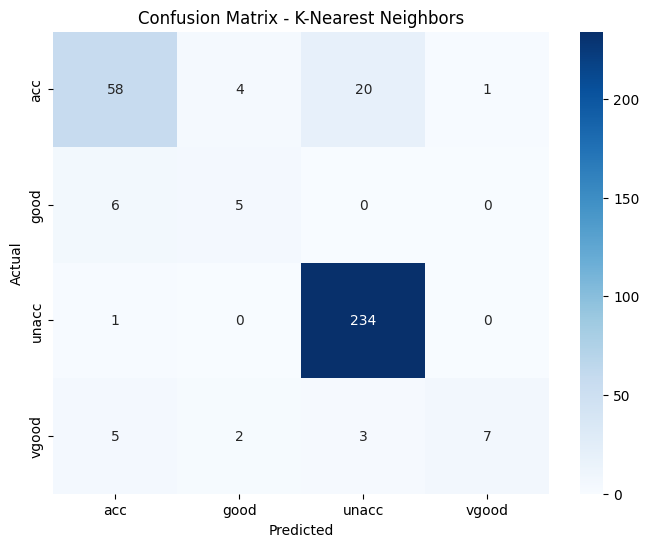


Categorical Naive Bayes:
              precision    recall  f1-score   support

           0       0.63      0.54      0.58        83
           1       0.57      0.36      0.44        11
           2       0.87      0.97      0.91       235
           3       1.00      0.35      0.52        17

    accuracy                           0.82       346
   macro avg       0.77      0.56      0.62       346
weighted avg       0.81      0.82      0.80       346



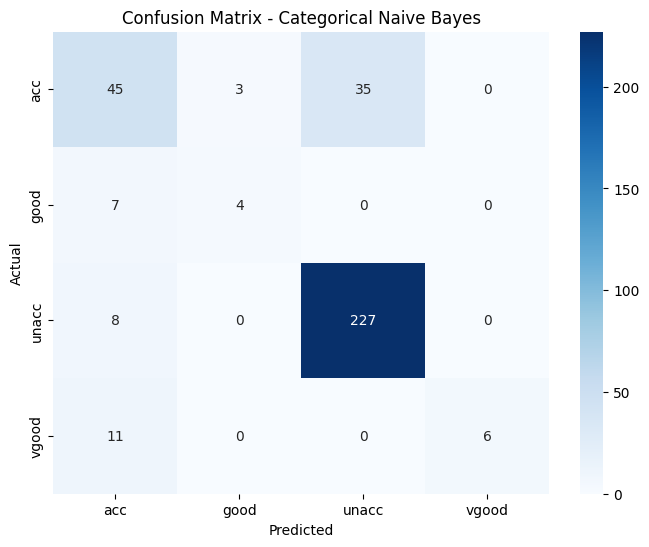


Best parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 2}

Decision Tree with best Hyperparameters:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        83
           1       0.62      0.91      0.74        11
           2       1.00      1.00      1.00       235
           3       1.00      0.94      0.97        17

    accuracy                           0.97       346
   macro avg       0.90      0.94      0.91       346
weighted avg       0.98      0.97      0.98       346



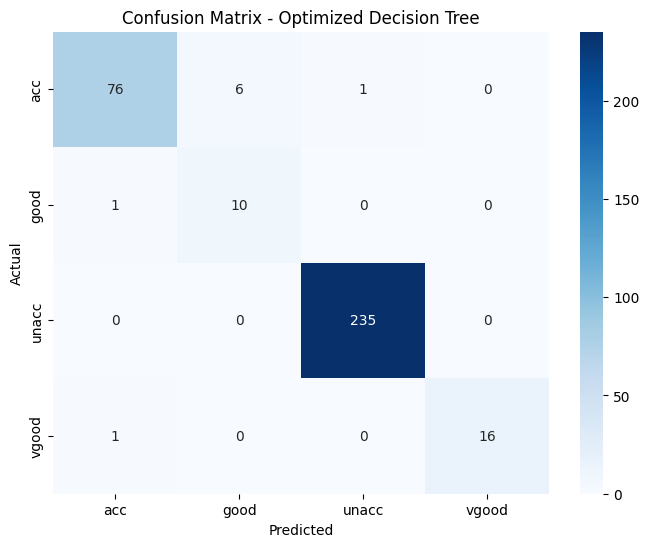

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pd.read_csv('car.data', header=None, names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'])
except FileNotFoundError:
    print("Error: 'car.data' not found. Please upload the dataset file.")
    exit()

# Preprocessing: Label Encoding
le = LabelEncoder()
for col in df.columns:
    df[col] = le.fit_transform(df[col])

# Separate features (X) and target (y)
X = df.drop('class', axis=1)
y = df['class']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
print("\nDecision Tree Classifier:")
print(classification_report(y_test, y_pred_dt))
plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree")

# KNeighborsClassifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
print("\nK-Nearest Neighbors Classifier:")
print(classification_report(y_test, y_pred_knn))
plot_confusion_matrix(y_test, y_pred_knn, "K-Nearest Neighbors")

# Categorical Naive Bayes
nb_classifier = CategoricalNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
print("\nCategorical Naive Bayes:")
print(classification_report(y_test, y_pred_nb))
plot_confusion_matrix(y_test, y_pred_nb, "Categorical Naive Bayes")

# Hyperparameter tuning with GridSearchCV (Decision Tree)
param_grid = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("\nBest parameters for Decision Tree:", grid_search.best_params_)

# Evaluate the best model
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test)
print("\nDecision Tree with best Hyperparameters:")
print(classification_report(y_test, y_pred_best))
plot_confusion_matrix(y_test, y_pred_best, "Optimized Decision Tree")